In [ ]:
!git clone https://github.com/benelot/pybullet-gym.git
!cd pybullet-gym

Cloning into 'pybullet-gym'...
remote: Enumerating objects: 804, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 804 (delta 21), reused 44 (delta 17), pack-reused 750
Receiving objects: 100% (804/804), 19.31 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (437/437), done.


In [ ]:
cd pybullet-gym

/content/pybullet-gym


In [ ]:
!pip install -e.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/pybullet-gym
     |████████████████████████████████| 91.7 MB 101 kB/s 
  Running setup.py develop for pybulletgym


In [ ]:
!pip install gym[box2d]
import gym
import pybulletgym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 130 kB/s 
     |████████████████████████████████| 374 kB 74.6 MB/s 
     |████████████████████████████████| 1.8 MB 48.8 MB/s 
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import os
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
#import pybullet_envs
from torch.distributions.normal import Normal
import tqdm
import random
#import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 1000 scores')
    plt.show()

In [ ]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, n_actions, fc1_dims=256, fc2_dims = 256,
                name='critic'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions= n_actions
        self.name = name
        
        self.fc1 = nn.Linear(self.input_dims[0]+ n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr= beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        self.to(self.device)
        
    def forward(self, state, action):
        action_value = self.fc1(T.cat([state,action], dim=1))
        action_value = F.relu(action_value)
        action_value = self.fc2(action_value)
        action_value = F.relu(action_value)
        
        q = self.q(action_value)
        
        return q

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims=256, fc2_dims = 256
                , name='value'):
        super(ValueNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        
        self.fc1 = nn .Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr= beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        print(self.device)
        
        self.to(self.device)
    
    def forward(self, state):
        action_value = self.fc1(state)
        action_value = F.relu(action_value)
        action_value = self.fc2(action_value)
        action_value = F.relu(action_value)
        
        v = self.v(action_value)
        
        return v 

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, beta, input_dims, max_action, fc1_dims=256, fc2_dims = 256,
                n_actions=2, name='value'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.max_action = max_action
        self.reparam_noise = 1e-6
        
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        self.sigma = nn.Linear(self.fc2_dims, self.n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr= beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        self.to(self.device)
        
    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)
        
        mu = self.mu(prob)
        sigma = self.sigma(prob)
        # Limits the deviation of the actions distribution to a certain limit
        sigma = T.clamp(sigma, min=self.reparam_noise, max=1)
        
        return mu, sigma
    
    def sample_normal(self, state, reparameterize = True):
        state = state.float()
        mu, sigma = self.forward(state)
        probabilities = Normal(mu, sigma)
        
        if reparameterize:
            #Actions seleted from a noise probability distribution
            actions = probabilities.rsample()
        else:
            #Actions selected from a normal probability distribution
            actions = probabilities.sample()
            
        action = T.tanh(actions)*T.tensor(self.max_action).to(self.device)
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1-action.pow(2)+self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

In [ ]:
class Agent():
    def __init__(self, alpha=0.0003, beta=0.0003, input_dims=[8],
            env=None, gamma=0.99, n_actions=2, max_size=1000000, tau=0.005,
            layer1_size=256, layer2_size=256, batch_size=256, reward_scale=2):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        
        self.actor = ActorNetwork(alpha, input_dims, n_actions=n_actions,
                                 name='actor', max_action= env.action_space.high)
        self.critic_1 = CriticNetwork(beta, input_dims, n_actions=n_actions,
                                     name="critic_1")
        self.critic_2 = CriticNetwork(beta, input_dims, n_actions=n_actions,
                                     name="critic_2")
        self.value = ValueNetwork(beta, input_dims, name='value')
        self.target_value = ValueNetwork(beta, input_dims, name='target_value')
        
        self.scale =reward_scale
        self.update_network_parameters(tau=1)
        
    def choose_action(self, observation):
        state = T.tensor([observation]).to(self.actor.device)
        actions, _ = self.actor.sample_normal(state, reparameterize= False)
        
        return actions.cpu().detach().numpy()[0]
    
    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)
        
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        target_value_params = self.target_value.named_parameters()
        value_params = self.value.named_parameters()

        target_value_state_dict = dict(target_value_params)
        value_state_dict = dict(value_params)

        for name in value_state_dict:
            value_state_dict[name] = tau*value_state_dict[name].clone() + \
                    (1-tau)*target_value_state_dict[name].clone()

        self.target_value.load_state_dict(value_state_dict)
    
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)
        state_ = T.tensor(new_state, dtype=T.float).to(self.actor.device)
        state = T.tensor(state, dtype=T.float).to(self.actor.device)
        action = T.tensor(action, dtype=T.float).to(self.actor.device)

        value = self.value(state).view(-1)
        value_ = self.target_value(state_).view(-1)
        value_[done] = 0.0

        actions, log_probs = self.actor.sample_normal(state, reparameterize=False)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(state, actions)
        q2_new_policy = self.critic_2.forward(state, actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        critic_value = critic_value.view(-1)

        self.value.optimizer.zero_grad()
        value_target = critic_value - log_probs
        value_loss = 0.5 * F.mse_loss(value, value_target)
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()

        actions, log_probs = self.actor.sample_normal(state, reparameterize=True)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(state, actions)
        q2_new_policy = self.critic_2.forward(state, actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        critic_value = critic_value.view(-1)
        
        actor_loss = log_probs - critic_value
        actor_loss = T.mean(actor_loss)
        self.actor.optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor.optimizer.step()

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        q_hat = self.scale*reward + self.gamma*value_
        q1_old_policy = self.critic_1.forward(state, action).view(-1)
        q2_old_policy = self.critic_2.forward(state, action).view(-1)
        critic_1_loss = 0.5 * F.mse_loss(q1_old_policy, q_hat)
        critic_2_loss = 0.5 * F.mse_loss(q2_old_policy, q_hat)

        critic_loss = critic_1_loss + critic_2_loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.update_network_parameters()

In [ ]:
env = gym.make('LunarLanderContinuous-v2')

agent = Agent(input_dims=env.observation_space.shape, env=env,
        n_actions=env.action_space.shape[0])
n_games = 1000
# uncomment this line and do a mkdir tmp && mkdir video if you want to
# record video of the agent playing the game.
#env = wrappers.Monitor(env, 'tmp/video', video_callable=lambda episode_id: True, force=True)
# filename = 'inverted_pendulum.png'

# figure_file = 'plots/' + filename

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

# if load_checkpoint:
#     agent.load_models()
#     env.render(mode='human')

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.remember(observation, action, reward, observation_, done)
        if not load_checkpoint:
            agent.learn()
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
#         if not load_checkpoint:
#             agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history)

NameError: ignored

In [ ]:
env = gym.make('HalfCheetahPyBulletEnv-v0')

agent = Agent(input_dims=env.observation_space.shape, env=env,
        n_actions=env.action_space.shape[0])
n_games = 1000
# uncomment this line and do a mkdir tmp && mkdir video if you want to
# record video of the agent playing the game.
#env = wrappers.Monitor(env, 'tmp/video', video_callable=lambda episode_id: True, force=True)
# filename = 'inverted_pendulum.png'

# figure_file = 'plots/' + filename

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

# if load_checkpoint:
#     agent.load_models()
#     env.render(mode='human')

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.remember(observation, action, reward, observation_, done)
        if not load_checkpoint:
            agent.learn()
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
#         if not load_checkpoint:
#             agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history)

NameError: ignored

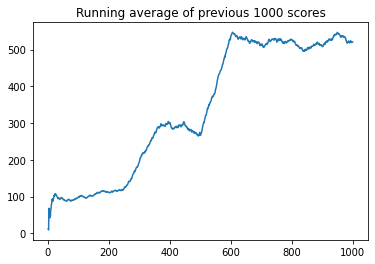